<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Images" data-toc-modified-id="Images-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Images</a></span><ul class="toc-item"><li><span><a href="#Test-thr" data-toc-modified-id="Test-thr-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Test thr</a></span></li><li><span><a href="#Full-train" data-toc-modified-id="Full-train-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Full train</a></span></li></ul></li><li><span><a href="#Vision-transformer" data-toc-modified-id="Vision-transformer-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Vision transformer</a></span></li><li><span><a href="#Texts" data-toc-modified-id="Texts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Texts</a></span><ul class="toc-item"><li><span><a href="#train-with-freeze" data-toc-modified-id="train-with-freeze-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>train with freeze</a></span></li><li><span><a href="#train-with-freeze-full-data" data-toc-modified-id="train-with-freeze-full-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>train with freeze full data</a></span></li><li><span><a href="#No-train-test" data-toc-modified-id="No-train-test-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>No train test</a></span></li></ul></li><li><span><a href="#Effnet-image" data-toc-modified-id="Effnet-image-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Effnet image</a></span><ul class="toc-item"><li><span><a href="#b0" data-toc-modified-id="b0-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>b0</a></span></li><li><span><a href="#TF-b3" data-toc-modified-id="TF-b3-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>TF b3</a></span></li><li><span><a href="#TF-b0" data-toc-modified-id="TF-b0-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>TF b0</a></span></li><li><span><a href="#b2" data-toc-modified-id="b2-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>b2</a></span></li><li><span><a href="#b3" data-toc-modified-id="b3-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>b3</a></span></li></ul></li></ul></div>

## Images

### Test thr

In [9]:
from imports import *
from utils import load_data
from image_train.data import create_dl, ImageDS
from image_train.model import EMBRes
from arcface import ArcMarginProduct, compute_centers
from image_train.train import *
import matplotlib.pyplot as plt
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [3]:
# creating dataloaders
small_images_dir = 'data/small_train_images/'

tr_dl = create_dl(train_df, small_images_dir)
tr_test_dl = create_dl(train_df, small_images_dir, shuffle=False)
val_dl = create_dl(val_df, small_images_dir, shuffle=False)
full_dl = create_dl(df, small_images_dir, shuffle=False)

***Embeddings normalization is not done in the model but in the arcface metric***

In [10]:
vision_model = 'resnet50'
model = timm.create_model(vision_model, pretrained=True, num_classes=0).to('cuda')
train_tfms, val_tfms = get_tfms()

In [5]:
#centers = compute_centers(tr_test_dl, model, val_tfms, train_df)
#torch.save(centers, 'centers.pth')

In [6]:
centers = torch.load('centers.pth')

In [7]:
metric_fc = ArcMarginProduct(2048, train_df['label_group'].nunique(), 
                             s=30, m=0.5, easy_margin=False, centers=centers).to(device)

Using center as wieghts


In [9]:
freeze(model)
unfreeze_resnet_to(model, 4)
#freeze(metric_fc)
#freeze_resnet_to()

In [8]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=30)

In [9]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/tests_model_image/test_2ap'

In [10]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/tests_model_image/test_2ap_ep_0.pth


Saved best model ep 0 with f score : 0.6539213952945385
Ep 0: Train loss 8.4841 | Val f score 0.6539 with thresh 0.56, train f score 0.6424 with thresh 0.73


Saved best model ep 1 with f score : 0.6598487066839794
Ep 1: Train loss 7.4000 | Val f score 0.6598 with thresh 0.61, train f score 0.6839 with thresh 0.73


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_2.pth


Saved best model ep 2 with f score : 0.6640861977570627
Ep 2: Train loss 6.4254 | Val f score 0.6641 with thresh 0.61, train f score 0.7200 with thresh 0.73


Saved best model ep 3 with f score : 0.6686500246267384
Ep 3: Train loss 5.7513 | Val f score 0.6687 with thresh 0.66, train f score 0.7602 with thresh 0.78


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_4.pth


Saved best model ep 4 with f score : 0.6727810015973045
Ep 4: Train loss 5.2273 | Val f score 0.6728 with thresh 0.66, train f score 0.7904 with thresh 0.83


Saved best model ep 5 with f score : 0.677263212554363
Ep 5: Train loss 4.9342 | Val f score 0.6773 with thresh 0.66, train f score 0.8100 with thresh 0.83


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_6.pth


Ep 6: Train loss 4.5580 | Val f score 0.6758 with thresh 0.66, train f score 0.8284 with thresh 0.88


Saved best model ep 7 with f score : 0.6792021981862947
Ep 7: Train loss 4.0822 | Val f score 0.6792 with thresh 0.66, train f score 0.8484 with thresh 0.88


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_8.pth


Saved best model ep 8 with f score : 0.681711585931827
Ep 8: Train loss 3.5823 | Val f score 0.6817 with thresh 0.71, train f score 0.8665 with thresh 0.93


Ep 9: Train loss 2.7346 | Val f score 0.6792 with thresh 0.71, train f score 0.8980 with thresh 0.93


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_10.pth


Saved best model ep 10 with f score : 0.683788558641284
Ep 10: Train loss 2.2245 | Val f score 0.6838 with thresh 0.71, train f score 0.9149 with thresh 0.93


Ep 11: Train loss 1.9659 | Val f score 0.6805 with thresh 0.76, train f score 0.9251 with thresh 0.93


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_12.pth


Ep 12: Train loss 1.4246 | Val f score 0.6782 with thresh 0.76, train f score 0.9439 with thresh 0.93


Ep 13: Train loss 1.2263 | Val f score 0.6816 with thresh 0.76, train f score 0.9522 with thresh 0.93


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_14.pth


Ep 14: Train loss 0.8361 | Val f score 0.6795 with thresh 0.76, train f score 0.9672 with thresh 0.93


Ep 15: Train loss 0.6380 | Val f score 0.6809 with thresh 0.76, train f score 0.9736 with thresh 0.93


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_16.pth


Saved best model ep 16 with f score : 0.6858966853338684
Ep 16: Train loss 0.5020 | Val f score 0.6859 with thresh 0.76, train f score 0.9802 with thresh 0.93


Ep 17: Train loss 0.3622 | Val f score 0.6841 with thresh 0.76, train f score 0.9850 with thresh 0.93


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_18.pth


Ep 18: Train loss 0.2593 | Val f score 0.6805 with thresh 0.76, train f score 0.9882 with thresh 0.93


Ep 19: Train loss 0.2282 | Val f score 0.6844 with thresh 0.76, train f score 0.9899 with thresh 0.93


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_20.pth


Ep 20: Train loss 0.1764 | Val f score 0.6836 with thresh 0.76, train f score 0.9914 with thresh 0.93


Saved best model ep 21 with f score : 0.686430300286656
Ep 21: Train loss 0.1153 | Val f score 0.6864 with thresh 0.76, train f score 0.9936 with thresh 0.93


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_22.pth


Ep 22: Train loss 0.0862 | Val f score 0.6851 with thresh 0.76, train f score 0.9949 with thresh 0.93


Ep 23: Train loss 0.0773 | Val f score 0.6856 with thresh 0.76, train f score 0.9950 with thresh 0.93


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_24.pth


Ep 24: Train loss 0.0737 | Val f score 0.6852 with thresh 0.76, train f score 0.9951 with thresh 0.88


Ep 25: Train loss 0.0702 | Val f score 0.6853 with thresh 0.76, train f score 0.9953 with thresh 0.93


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_26.pth


Ep 26: Train loss 0.0702 | Val f score 0.6854 with thresh 0.76, train f score 0.9952 with thresh 0.88


Ep 27: Train loss 0.0718 | Val f score 0.6854 with thresh 0.76, train f score 0.9953 with thresh 0.93


Checkpoint : saved model to data/tests_model_image/test_2ap_ep_28.pth


Ep 28: Train loss 0.0615 | Val f score 0.6855 with thresh 0.76, train f score 0.9955 with thresh 0.93


Ep 29: Train loss 0.0642 | Val f score 0.6851 with thresh 0.76, train f score 0.9953 with thresh 0.93


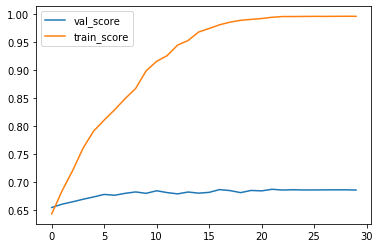

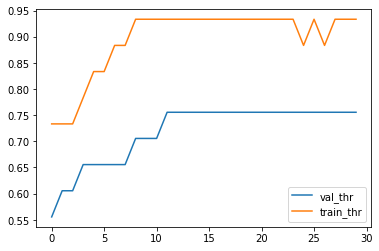

In [11]:
plot_hist(thr_score_hist)

In [13]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=8e-5, n_epochs=4)
unfreeze_resnet_to(model, 3)

In [14]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Saved best model ep 0 with f score : 0.6813904524741098
Ep 0: Train loss 2.2102 | Val f score 0.68 with thresh 0.70, train f score 0.7800 with thresh 0.60


Saved best model ep 1 with f score : 0.6824626754703321
Ep 1: Train loss 2.1734 | Val f score 0.68 with thresh 0.70, train f score 0.7690 with thresh 0.60


Saved best model ep 2 with f score : 0.6835254539227448
Ep 2: Train loss 1.6577 | Val f score 0.68 with thresh 0.70, train f score 0.7955 with thresh 0.60


Saved best model ep 3 with f score : 0.6848199293332125
Ep 3: Train loss 1.3072 | Val f score 0.68 with thresh 0.70, train f score 0.8194 with thresh 0.60


In [15]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=6e-6, n_epochs=3)
unfreeze_resnet_to(model, 2)

In [16]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Saved best model ep 0 with f score : 0.6840672685160704
Ep 0: Train loss 1.2826 | Val f score 0.68 with thresh 0.70, train f score 0.8173 with thresh 0.60


Saved best model ep 1 with f score : 0.6845468000185544
Ep 1: Train loss 1.2622 | Val f score 0.68 with thresh 0.70, train f score 0.8204 with thresh 0.60


Saved best model ep 2 with f score : 0.6848298176747182
Ep 2: Train loss 1.2199 | Val f score 0.68 with thresh 0.70, train f score 0.8199 with thresh 0.60


In [17]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-6, n_epochs=2)
unfreeze(model)

In [18]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Saved best model ep 0 with f score : 0.6853407440391863
Ep 0: Train loss 1.1990 | Val f score 0.69 with thresh 0.70, train f score 0.8228 with thresh 0.60


Ep 1: Train loss 1.2221 | Val f score 0.68 with thresh 0.70, train f score 0.8219 with thresh 0.60


In [10]:
model.load_state_dict(torch.load('data/tests_model_image/jason_bourne_best.pth'))

<All keys matched successfully>

### Full train

In [1]:
from imports import *
from utils import load_data
from image_train.data import create_dl, ImageDS
from image_train.model import EMBRes
from arcface import ArcMarginProduct, compute_centers
from image_train.train import *
import matplotlib.pyplot as plt
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=1)

In [3]:
# creating dataloaders
small_images_dir = 'data/small_train_images/'

tr_dl = create_dl(train_df, small_images_dir)
tr_test_dl = create_dl(train_df, small_images_dir, shuffle=False)
full_dl = create_dl(df, small_images_dir, shuffle=False)

***Embeddings normalization is not done in the model but in the arcface metric***

In [4]:
vision_model = 'resnet50'
model = timm.create_model(vision_model, pretrained=True, num_classes=0).to('cuda')
train_tfms, val_tfms = get_tfms()

In [5]:
#centers = compute_centers(tr_test_dl, model, val_tfms, train_df)
#torch.save(centers, 'centers_full.pth')

In [6]:
centers = torch.load('centers_full.pth')

In [7]:
metric_fc = ArcMarginProduct(2048, train_df['label_group'].nunique(), 
                             s=30, m=0.5, easy_margin=False, centers=centers).to(device)

Using center as wieghts


In [8]:
freeze(model)
unfreeze_resnet_to(model, 4)
#freeze(metric_fc)
#freeze_resnet_to()

In [9]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=5)

In [10]:
loss_hist = []
best_thr_score={'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/tests_model_image/1april/resnet50_full'

In [11]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/tests_model_image/1april/resnet50_full_ep_0.pth
Ep 0: Loss 10.1480 | F score 0.6212 with thresh 0.73


Ep 1: Loss 9.5412 | F score 0.6751 with thresh 0.78


Checkpoint : saved model to data/tests_model_image/1april/resnet50_full_ep_2.pth
Ep 2: Loss 7.3100 | F score 0.7259 with thresh 0.83


Ep 3: Loss 5.1566 | F score 0.7665 with thresh 0.88


Checkpoint : saved model to data/tests_model_image/1april/resnet50_full_ep_4.pth
Ep 4: Loss 3.7504 | F score 0.8052 with thresh 0.88


In [12]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=9e-5, n_epochs=4)
unfreeze_resnet_to(model, 3)

In [13]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Ep 5: Loss 3.6675 | F score 0.8121 with thresh 0.88


Checkpoint : saved model to data/tests_model_image/1april/resnet50_full_ep_6.pth
Ep 6: Loss 3.7566 | F score 0.8147 with thresh 0.88


Ep 7: Loss 3.0844 | F score 0.8391 with thresh 0.88


Checkpoint : saved model to data/tests_model_image/1april/resnet50_full_ep_8.pth
Ep 8: Loss 2.5585 | F score 0.8615 with thresh 0.88


In [14]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=3e-5, n_epochs=3)
unfreeze_resnet_to(model, 2)thresh

In [15]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Ep 9: Loss 2.5297 | F score 0.8629 with thresh 0.88


Checkpoint : saved model to data/tests_model_image/1april/resnet50_full_ep_10.pth
Ep 10: Loss 2.4658 | F score 0.8651 with thresh 0.88


Ep 11: Loss 2.2163 | F score 0.8768 with thresh 0.93


In [16]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=7e-6, n_epochs=2)
unfreeze(model)

In [17]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/tests_model_image/1april/resnet50_full_ep_12.pth
Ep 12: Loss 2.1807 | F score 0.8799 with thresh 0.88


Ep 13: Loss 2.1233 | F score 0.8827 with thresh 0.93


In [19]:
torch.save(model.state_dict(), save_path + 'last.pth')

In [18]:
model.load_state_dict(torch.load(save_path + '§1.pth'))

FileNotFoundError: [Errno 2] No such file or directory: 'data/tests_model_image/1april/resnet50_fullbest.pth'

## Vision transformer

In [1]:
from imports import *
from utils import load_data
from image_train.data import create_dl, ImageDS
from image_train.model import EMBRes
from arcface import ArcMarginProduct, compute_centers
from image_train.train import *
import matplotlib.pyplot as plt
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=1)

In [3]:
# creating dataloaders
small_images_dir = 'data/small_train_images/'

tr_dl = create_dl(train_df, small_images_dir)
tr_test_dl = create_dl(train_df, small_images_dir, shuffle=False)
full_dl = create_dl(df, small_images_dir, shuffle=False)

***Embeddings normalization is not done in the model but in the arcface metric***

In [4]:
vision_model = 'resnet50'
model = timm.create_model(vision_model, pretrained=True, num_classes=0).to('cuda')
train_tfms, val_tfms = get_tfms()

In [ ]:
centers = compute_centers(tr_test_dl, model, val_tfms, train_df)
torch.save(centers, 'centers_full_effb3.pth')

In [5]:
centers = torch.load('centers_full.pth')

In [6]:
metric_fc = ArcMarginProduct(2048, train_df['label_group'].nunique(), 
                             s=30, m=0.5, easy_margin=False, centers=centers).to(device)

Using center as wieghts


In [7]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=30)

In [8]:
loss_hist = []
best_thr_score={'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/tests_model_image/1april/model_full_nofrezze'

In [9]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_0.pth
Ep 0: Loss 9.5217 | F score 0.6199 with thresh 0.64


Ep 1: Loss 8.5159 | F score 0.6520 with thresh 0.69


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_2.pth
Ep 2: Loss 7.8212 | F score 0.6752 with thresh 0.74


Ep 3: Loss 7.3146 | F score 0.7029 with thresh 0.74


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_4.pth
Ep 4: Loss 7.0361 | F score 0.7220 with thresh 0.79


Ep 5: Loss 6.7008 | F score 0.7399 with thresh 0.84


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_6.pth
Ep 6: Loss 6.3737 | F score 0.7545 with thresh 0.84


Ep 7: Loss 5.9146 | F score 0.7735 with thresh 0.89


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_8.pth
Ep 8: Loss 5.3383 | F score 0.7922 with thresh 0.89


Ep 9: Loss 4.6596 | F score 0.8113 with thresh 0.94


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_10.pth
Ep 10: Loss 4.0444 | F score 0.8324 with thresh 0.94


Ep 11: Loss 3.5480 | F score 0.8483 with thresh 0.94


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_12.pth
Ep 12: Loss 3.0807 | F score 0.8652 with thresh 0.94


Ep 13: Loss 2.7150 | F score 0.8766 with thresh 0.94


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_14.pth
Ep 14: Loss 2.2196 | F score 0.8947 with thresh 0.94


Ep 15: Loss 1.8490 | F score 0.9097 with thresh 0.94


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_16.pth
Ep 16: Loss 1.5134 | F score 0.9231 with thresh 0.99


Ep 17: Loss 1.1863 | F score 0.9374 with thresh 0.99


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_18.pth
Ep 18: Loss 0.9500 | F score 0.9476 with thresh 0.99


Ep 19: Loss 0.7685 | F score 0.9559 with thresh 0.99


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_20.pth
Ep 20: Loss 0.6183 | F score 0.9633 with thresh 0.99


Ep 21: Loss 0.5042 | F score 0.9686 with thresh 0.99


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_22.pth
Ep 22: Loss 0.4358 | F score 0.9719 with thresh 0.94


Ep 23: Loss 0.3723 | F score 0.9756 with thresh 0.94


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_24.pth
Ep 24: Loss 0.3357 | F score 0.9782 with thresh 0.99


Ep 25: Loss 0.2992 | F score 0.9794 with thresh 0.99


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_26.pth
Ep 26: Loss 0.2738 | F score 0.9809 with thresh 0.94


Ep 27: Loss 0.2535 | F score 0.9824 with thresh 0.99


Checkpoint : saved model to data/tests_model_image/1april/model_full_nofrezze_ep_28.pth
Ep 28: Loss 0.2429 | F score 0.9829 with thresh 0.99


Ep 29: Loss 0.2358 | F score 0.9830 with thresh 0.99


## Texts

### train with freeze

In [1]:
from utils import compute_f1, load_data
from text_train.imports import *
from text_train.data import TextDS, text_to_device
from arcface import ArcMarginProduct
from text_train.model import EMBBert
from text_train.train import *
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
from imports import *

In [3]:
def plot_hist(history) : 
    train_scores = [info['train']['f1'] for info in history]
    train_thr = [info['train']['thr'] for info in history]
    val_scores = [info['val']['f1'] for info in history]
    val_thr = [info['val']['thr'] for info in history]
    x = range(len(train_scores))
    plt.plot(x, val_scores, label='val_score')
    plt.plot(x, train_scores, label='train_score')
    plt.legend()
    plt.show()
    plt.plot(x, val_thr, label='val_thr')
    plt.plot(x, train_thr, label='train_thr')
    plt.legend()
    plt.show()

In [4]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [5]:
bs = 64
language_model = 'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(language_model)

tr_ds = TextDS(train_df, tokenizer)
tr_test_dl = DataLoader(tr_ds, batch_size = bs, shuffle = False, pin_memory = True)

tr_ds = TextDS(train_df, tokenizer)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)

val_ds = TextDS(val_df, tokenizer)
val_dl = DataLoader(val_ds, batch_size = bs, shuffle = False, pin_memory = True)

full_ds = TextDS(df, tokenizer)
full_dl = DataLoader(full_ds, batch_size = bs, shuffle = False, pin_memory = True)

torch.save(tr_test_dl, 'data/text_models/tr_test_dl_0.3.pth')
torch.save(tr_dl, 'data/text_models/tr_dl_0.3.pth')
torch.save(val_dl, 'data/text_models/val_dl_0.3.pth')
torch.save(full_dl, 'data/text_models/full_dl_0.3.pth')

In [6]:
tr_dl = torch.load('data/text_models/tr_dl_0.3.pth')
val_dl = torch.load('data/text_models/val_dl_0.3.pth')
tr_test_dl = torch.load('data/text_models/tr_test_dl_0.3.pth')
full_dl = torch.load('data/text_models/full_dl_0.3.pth')

In [7]:
# model
model = EMBBert(language_model).to(device)

centers = compute_centers(tr_test_dl, model, train_df)
torch.save(centers, 'data/text_models/centers_0.3.pth')

In [8]:
centers = torch.load('data/text_models/centers_0.3.pth')

In [9]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), s=30, m=0.5,
                             easy_margin=False, centers=centers, device=device).to(device)

Using center as wieghts


In [13]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=5)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [14]:
unfreeze_bert_to(model, 10)

Unfroze 32 parameters


In [15]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/text_models/test_3n_epochs'

In [16]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, device=device)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/test_3ap_ep_0.pth


Saved best model ep 0 with f score : 0.6001494931589628
Ep 0: Train loss 10.6992 | Val f score 0.6001 with thresh 0.56, train f score 0.5741 with thresh 0.64


Saved best model ep 1 with f score : 0.6277116685801583
Ep 1: Train loss 9.3118 | Val f score 0.6277 with thresh 0.66, train f score 0.6530 with thresh 0.74


Checkpoint : saved model to data/text_models/test_3ap_ep_2.pth


Saved best model ep 2 with f score : 0.6397538938208261
Ep 2: Train loss 6.8955 | Val f score 0.6398 with thresh 0.76, train f score 0.7393 with thresh 0.84


Saved best model ep 3 with f score : 0.6474627951197889
Ep 3: Train loss 4.8839 | Val f score 0.6475 with thresh 0.76, train f score 0.7989 with thresh 0.89


Checkpoint : saved model to data/text_models/test_3ap_ep_4.pth


Saved best model ep 4 with f score : 0.6481900406991484
Ep 4: Train loss 3.8192 | Val f score 0.6482 with thresh 0.76, train f score 0.8346 with thresh 0.89


In [17]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-4, n_epochs=2)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [18]:
unfreeze_bert_to(model, 6)

Unfroze 96 parameters


In [19]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, device=device)
loss_hist.append(losses)
ep_start += n_epochs

Saved best model ep 5 with f score : 0.6587867599411823
Ep 5: Train loss 3.7791 | Val f score 0.6588 with thresh 0.76, train f score 0.8426 with thresh 0.89


Checkpoint : saved model to data/text_models/test_3ap_ep_6.pth


Ep 6: Train loss 3.0978 | Val f score 0.6583 with thresh 0.76, train f score 0.8699 with thresh 0.89


In [20]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-5, n_epochs=2)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [21]:
unfreeze(model)

In [22]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, device=device)
loss_hist.append(losses)
ep_start += n_epochs

Saved best model ep 7 with f score : 0.6611133421224951
Ep 7: Train loss 2.7312 | Val f score 0.6611 with thresh 0.76, train f score 0.8799 with thresh 0.89


Checkpoint : saved model to data/text_models/test_3ap_ep_8.pth


Saved best model ep 8 with f score : 0.6618433112378985
Ep 8: Train loss 2.5136 | Val f score 0.6618 with thresh 0.76, train f score 0.8905 with thresh 0.89


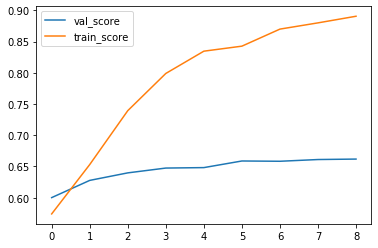

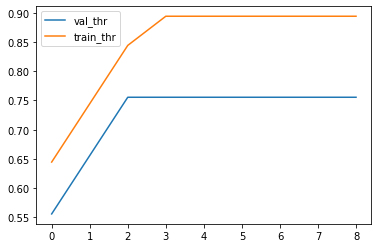

In [23]:
plot_hist(thr_score_hist)

In [10]:
torch.save(model.text_embedor, 'data/text_models/bert_final_10ep_text_emb.pth')

In [11]:
torch.save(model.state_dict(), 'data/text_models/bert_final_10ep_sd.pth')

In [9]:
torch.save(tokenizer, 'data/text_models/bert_tokenizer.pth')

In [7]:
with torch.no_grad():
    pbar = tqdm(full_dl, leave=False)
    text_embeddings = []
    for txts, _ in pbar:
        txts = text_to_device(txts, device)
        feature =  model(txts)
        text_embeddings.append(feature)
    text_embeddings = F.normalize(torch.cat(text_embeddings, 0))

In [8]:
text_embeddings.shape

torch.Size([34250, 768])

In [13]:
compute_f1(text_embeddings, df['label_group'], 0.5)

f1 score : 0.5241056886066721 | precision : 0.7149890345780057 | recall : 0.5488528699864234


(0.5241056886066721, 0.7149890345780057, 0.5488528699864234)

### train with freeze full data

In [1]:
from utils import compute_f1, load_data
from text_train.imports import *
from text_train.data import TextDS, text_to_device
from arcface import ArcMarginProduct
from text_train.model import EMBBert
from text_train.train import *
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
from imports import *

In [3]:
def plot_hist(history) : 
    train_scores = [info['train']['f1'] for info in history]
    train_thr = [info['train']['thr'] for info in history]
    val_scores = [info['val']['f1'] for info in history]
    val_thr = [info['val']['thr'] for info in history]
    x = range(len(train_scores))
    plt.plot(x, val_scores, label='val_score')
    plt.plot(x, train_scores, label='train_score')
    plt.legend()
    plt.show()
    plt.plot(x, val_thr, label='val_thr')
    plt.plot(x, train_thr, label='train_thr')
    plt.legend()
    plt.show()

In [4]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=1)

In [5]:
bs = 16
language_model = 'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(language_model)

In [ ]:
tr_ds = TextDS(train_df, tokenizer)
tr_test_dl = DataLoader(tr_ds, batch_size = bs, shuffle = False, pin_memory = True)

tr_ds = TextDS(train_df, tokenizer)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)

In [ ]:
torch.save(tr_test_dl, 'data/text_models/tr_test_dl_full.pth')
torch.save(tr_dl, 'data/text_models/tr_dl_full.pth')

In [6]:
tr_dl = torch.load('data/text_models/tr_dl_full.pth')
tr_test_dl = torch.load('data/text_models/tr_test_dl_full.pth')

In [7]:
# model
model = EMBBert(language_model).to(device)

centers = compute_centers(tr_test_dl, model, train_df)
torch.save(centers, 'data/text_models/centers_full.pth')

In [10]:
centers = torch.load('data/text_models/centers_full.pth')

In [11]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), s=30, m=0.5,
                             easy_margin=False, centers=centers, device=device).to(device)

Using center as wieghts


In [10]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=5)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [11]:
unfreeze_bert_to(model, 10)

Unfroze 32 parameters


In [13]:
loss_hist = []
best_thr_score={'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/text_models/2april'

In [13]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/2april_ep_0.pth
Ep 0: Loss 11.4460 | F score 0.5088 with thresh 0.64


Ep 1: Loss 10.1777 | F score 0.5531 with thresh 0.74


Checkpoint : saved model to data/text_models/2april_ep_2.pth
Ep 2: Loss 7.6275 | F score 0.6458 with thresh 0.84


Ep 3: Loss 5.2639 | F score 0.7408 with thresh 0.94


Checkpoint : saved model to data/text_models/2april_ep_4.pth
Ep 4: Loss 3.8014 | F score 0.7810 with thresh 0.94


torch.save(metric_fc.state_dict(), save_path+'_met_1fr.pth')

In [12]:
metric_fc.load_state_dict(torch.load(save_path+'_met_1fr.pth'))

<All keys matched successfully>

In [13]:
model.load_state_dict(torch.load('data/text_models/2april_ep_4.pth'))

<All keys matched successfully>

In [14]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-4, n_epochs=2)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [15]:
freeze(model)
unfreeze_bert_to(model, 6)

Unfroze 96 parameters


In [16]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/2april_ep_0.pth
Ep 0: Loss 3.9497 | F score 0.7760 with thresh 0.91


Ep 1: Loss 3.1694 | F score 0.8175 with thresh 0.96


torch.save(metric_fc.state_dict(), save_path+'_met_3fr.pth')
torch.save(model.state_dict(), save_path+'_mod_3fr.pth')

In [14]:
model.load_state_dict(torch.load(save_path+'_mod_3fr.pth'))
metric_fc.load_state_dict(torch.load(save_path+'_met_3fr.pth'))

<All keys matched successfully>

In [15]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-5, n_epochs=2)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [16]:
unfreeze(model)

In [17]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/2april_ep_0.pth
Ep 0: Loss 2.6738 | F score 0.8324 with thresh 0.91


Ep 1: Loss 2.3517 | F score 0.8514 with thresh 0.96


In [18]:
torch.save(model.state_dict(), 'data/text_models/4ap_bert_8ep.pth')

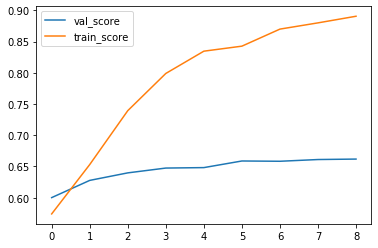

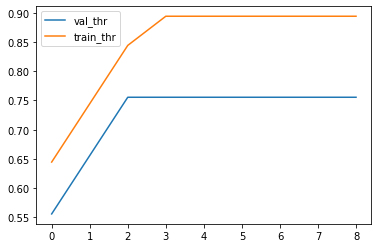

In [23]:
plot_hist(thr_score_hist)

### No train test

In [8]:
model.load_state_dict(torch.load('data/text_models/4ap_bert_8ep.pth'))

<All keys matched successfully>

model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [9]:
model.eval()
with torch.no_grad():
    pbar = tqdm(tr_test_dl, leave=False)
    embs = []
    for txts, _ in pbar:
        txts = text_to_device(txts, device)
        feature =  model(txts)
        embs.append(feature)
    embs = torch.cat(embs, 0)

In [14]:
torch.save(embs, 'data/text_embs/bertmulti_4ap.pth')

In [10]:
embs[0]

tensor([ 0.2382, -0.1216,  0.3433,  0.4693,  0.0672, -0.8577,  0.2648,  0.0217,
         0.2051, -0.0642, -0.0443, -0.3666,  0.4171,  0.5944, -0.2593, -0.3102,
         0.1456, -0.1105, -0.4717,  0.2841, -0.0559, -0.3004, -0.1875, -0.4790,
        -0.1663, -0.2223, -0.0750,  0.3664,  0.1350,  0.0313, -0.0846, -0.1551,
        -0.5078,  0.0983, -0.0549,  0.1436, -0.4476,  0.5313,  0.0747, -0.5308,
        -0.3245,  0.2828,  0.4038,  0.0660, -0.5474,  0.0403, -0.1574,  0.0808,
        -0.4188,  0.0085, -0.2077, -0.5169,  0.0304, -0.2926, -0.3524, -0.0917,
        -0.4470, -0.0627, -0.3675, -0.1950, -0.2660,  0.2865, -0.1969,  0.2587,
         0.2515, -0.3044, -0.0143, -0.0617, -0.0580, -0.0831,  0.2408,  0.2549,
         0.0910, -0.1716, -0.2711, -0.5112,  0.0345, -0.4528, -0.3019, -0.2169,
         0.2535,  0.4300,  0.2293, -0.1192,  0.0551, -0.5761, -0.1208,  0.2737,
        -0.3509,  0.4892,  0.1303, -0.1677, -0.1343,  0.1137, -0.0112,  0.2284,
        -0.3209,  0.2821,  0.1479,  0.03

In [15]:
embs.shape

torch.Size([34250, 768])

In [16]:
embs = F.normalize(embs)

In [18]:
compute_f1(embs, df['label_group'], [0.9])

({0.9: 0.8814814250072337}, 0.9, 0.8814814250072337)

In [19]:
??compute_f1

## Effnet image

In [1]:
import os
import random
import functools
from functools import partial
import PIL

import numpy as np 
import pandas as pd

from tqdm.notebook import tqdm
import math

import torch
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer
from transformers import BertModel

import matplotlib.pyplot as plt

import timm
np.random.seed(1337)


In [2]:
# load in data

df = pd.read_csv('data/train.csv')
small_images_dir = 'data/small_train_images/'
n_classes = df['label_group'].nunique()

labels = np.random.permutation(df['label_group'].unique())

train_perc = 0.7
train_idx = int(train_perc * len(labels))

train_labels = labels[:train_idx]
val_labels = labels[train_idx:]

In [3]:
train_df = df[df['label_group'].isin(train_labels)]
val_df = df[df['label_group'].isin(val_labels)]

In [4]:
val_df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
6,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137
8,train_86570404,0019a3c6755a194cb2e2c12bfc63972e.jpg,ea9af4f483249972,"[LOGU] Tempelan kulkas magnet angka, tempelan ...",2359912463


In [5]:
class SoftMaxDS(Dataset):
    def __init__(self, data, images_path, return_triplet = True):
        super().__init__()
        self.imgs = data['image'].tolist()
        self.unique_labels = data['label_group'].unique().tolist()
        self.labels = data['label_group'].astype('category')
        self.label_codes = self.labels.cat.codes
        
        self.images_path = images_path
        
    def __getitem__(self, idx):
        
        img = self._get_item(idx)
        label = self.label_codes.iloc[idx]
        return img, label
    def __len__(self):
        return len(self.imgs)
    
    def _get_item(self, idx):
        im = PIL.Image.open(os.path.join(self.images_path, self.imgs[idx]))
        im = torch.tensor(np.array(im) / 255.0, dtype = torch.float).permute(2,0,1)
        return im

In [6]:
# creating dataloaders

vision_model = 'resnet50'

bs = 64
tr_ds = SoftMaxDS(train_df, small_images_dir)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
tr_test_dl = DataLoader(tr_ds, batch_size = bs, shuffle = False, pin_memory = True)

val_ds = SoftMaxDS(val_df, small_images_dir)
val_dl = DataLoader(val_ds, batch_size = bs, shuffle = False, pin_memory = True)

full_ds = SoftMaxDS(df, small_images_dir)
full_dl = DataLoader(full_ds, batch_size = bs, shuffle = False, pin_memory = True)

device = torch.device('cuda')

val_label_count = val_df['label_group'].value_counts()

In [7]:
class EMBRes(nn.Module) :
    def __init__(self, pretrained_image_embedor='resnet50',
                output_dim=512) :
        super(EMBRes, self).__init__()
        self.image_embedor = timm.create_model(pretrained_image_embedor, pretrained=True, n_classes=0)
    
    def _get_embs(self, x) :
        images = x
        out_images = self.image_embedor.forward_features(images)
        out_images = self.image_pool(out_images).squeeze()
        #return F.normalize(out_images, dim=-1)
        return out_images
    
    def forward(self, x) :
        out_images = self._get_embs(x)
        
        return self.head(out_images)

In [8]:
# https://github.com/ronghuaiyang/arcface-pytorch

class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output


In [9]:
def compute_f1(embeddings, ls, threshold) :
    dists = torch.cdist(embeddings, embeddings)
    distances, indices = torch.topk(dists, 50, dim=1, largest=False)
    
    THRESHOLD = threshold
    preds = [[] for _ in range(embeddings.shape[0])]
    for i in tqdm(range(distances.shape[0]), leave=False) :
        IDX = torch.where(distances[i,]<THRESHOLD)[0]
        IDS = indices[i,IDX]
        preds[i] = IDS.cpu().numpy()
            
    label_counts = ls.value_counts()
    f_score = 0 
    precision = 0
    recall = 0
    for i in tqdm(range(embeddings.shape[0]), leave=False) :
        tp = 0
        fp = 0
        true_label = ls.iloc[i]
        for index in preds[i] :
            if ls.iloc[index] == true_label :
                tp += 1
            else :
                fp += 1
        fn = label_counts[true_label] - tp
        #print(label_counts[true_label]-1, tp)
        f_score += 2*tp / (label_counts[true_label] + len(preds[i]))
        precision += tp / len(preds[i])
        recall += tp/ label_counts[true_label]
    f_score = f_score/embeddings.shape[0]
    precision = precision/embeddings.shape[0]
    recall = recall/embeddings.shape[0]
    
    print('f1 score : {} | precision : {} | recall : {}'.format(f_score, precision, recall))
    return f_score, precision, recall

***Embeddings normalization is not done in the model but in the arcface metric***

In [10]:
#model = EMBRes('efficientnet_b0').to(device)
#metric_fc = ArcMarginProduct(512, df['label_group'].nunique(), s=30, m=0.5, easy_margin=False).to(device)

In [11]:

normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))

train_transforms = transforms.Compose([transforms.ColorJitter(.3,.3,.3),
                                       transforms.RandomRotation(5),
                                       transforms.RandomCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       normalize
                                       ])

val_transforms = transforms.Compose([normalize
                                     ])

n_epochs = 30

lf = nn.CrossEntropyLoss()

lr = 1e-2
wd = 0
no_decay = ["bias", "BatchNorm2d.weight", "BatchNorm2d.bias", "LayerNorm.weight", 'LayerNorm.bias',
            "BatchNorm1d.weight", "BatchNorm1d.bias"]

params = list(model.named_parameters()) + list(metric_fc.named_parameters())
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in params if not any(nd in n for nd in no_decay)],
        "weight_decay": wd,
    },
    {
        "params": [p for n, p in  model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)

# learning rate scheduler
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr =lr, pct_start = 0.3, #anneal_strategy = 'linear',
                                            total_steps = int(n_epochs * len(tr_dl)))

NameError: name 'model' is not defined

### b0

In [24]:
small_images_dir = 'data/small_train_images_600/'
full_ds = SoftMaxDS(df, small_images_dir)
full_dl = DataLoader(full_ds, batch_size = bs, shuffle = False, pin_memory = True)

In [25]:
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0).to(device)

In [26]:
with torch.no_grad():
    pbar = tqdm(full_dl, leave=False)
    embs = []
    for imgs, _ in pbar:
        imgs = val_transforms(imgs.to(device))
        feature = model(imgs)
        embs.append(feature)
    embs = torch.cat(embs, 0)

In [38]:
torch.save(embs, 'data/effnet_embs/embs_b0_notrain_600.pth')

In [37]:
compute_f1(embs, df['label_group'], 6.6)

f1 score : 0.6363438917214435 | precision : 0.9273578644382607 | recall : 0.558110326058612


(0.6363438917214435, 0.9273578644382607, 0.558110326058612)

### TF b3

In [12]:
embs = torch.load('data/effnet_embs/image_embeddings.pth')

In [14]:
embs = torch.from_numpy(embs).float()

In [19]:
compute_f1(embs, df['label_group'], 5)

f1 score : 0.6409645357216606 | precision : 0.9576403504043125 | recall : 0.5480520553212448


(0.6409645357216606, 0.9576403504043125, 0.5480520553212448)

### TF b0

In [10]:
embs = torch.load('data/effnet_embs/tf_embs_b0_256.pth')

In [13]:
embs = torch.from_numpy(embs).float().to(device)

TypeError: expected np.ndarray (got Tensor)

In [21]:
compute_f1(embs, df['label_group'], 7.5)

f1 score : 0.642667609875153 | precision : 0.9084886567491639 | recall : 0.5867818006410631


(0.642667609875153, 0.9084886567491639, 0.5867818006410631)

### b2

In [10]:
model = timm.create_model('efficientnet_b2', pretrained=True, num_classes=0).to(device)

In [13]:
with torch.no_grad():
    pbar = tqdm(full_dl, leave=False)
    embs = []
    for imgs, _ in pbar:
        imgs = val_transforms(imgs.to(device))
        feature = model(imgs)
        embs.append(feature)
    embs = torch.cat(embs, 0)

In [22]:
compute_f1(embs, df['label_group'], 10)

f1 score : 0.6196357491479187 | precision : 0.9479240435254366 | recall : 0.5289644536998594


(0.6196357491479187, 0.9479240435254366, 0.5289644536998594)

In [24]:
#torch.save(embs, 'data/effnet_embs/embs_b2_notrain.pth')

### b3

In [ ]:
small_images_dir = 'data/small_train_images_300/'
full_ds = SoftMaxDS(df, small_images_dir)
full_dl = DataLoader(full_ds, batch_size = bs, shuffle = False, pin_memory = True)

In [12]:
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0).to(device)

In [13]:
with torch.no_grad():
    pbar = tqdm(full_dl, leave=False)
    embs = []
    for imgs, _ in pbar:
        imgs = val_transforms(imgs.to(device))
        feature = model(imgs)
        embs.append(feature)
    embs = torch.cat(embs, 0)

In [22]:
compute_f1(embs, df['label_group'], 8.1)

f1 score : 0.60674607145152 | precision : 0.9222303967400572 | recall : 0.5332024273267191


(0.60674607145152, 0.9222303967400572, 0.5332024273267191)

In [15]:
torch.save(embs, 'data/effnet_embs/embs_b3_notrain.pth')

In [11]:
embs = torch.load('data/effnet_embs/embs_b3_notrain.pth')